# Identify tags in airline database

## LSTM network

    - Improving the model of: 00_identify_tags_in_airline_database_embedings - SOLVED  


In [2]:
from __future__ import print_function

import sys
import os 
import numpy as np 
import tensorflow as tf 
print(tf.__version__)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 

1.3.0


## Dataset transformation


In [3]:
# Read data
import pickle

atis_file = '../data/atis/atis.pkl'

with open(atis_file,'rb') as f:
    if sys.version_info.major==2:
        train, test, dicts = pickle.load(f) #python2.7
    else:
        train, test, dicts = pickle.load(f, encoding='bytes') #python3

#Dictionaries and train test partition
w2idx, ne2idx, labels2idx = dicts[b'words2idx'], dicts[b'tables2idx'], dicts[b'labels2idx']
    
idx2w  = dict((v,k) for k,v in w2idx.items())
idx2la = dict((v,k) for k,v in labels2idx.items())

train_x, _, train_label = train
test_x,  _,  test_label  = test


# Max value of word coding to assign the ID_PAD
ID_PAD = np.max([np.max(tx) for tx in train_x]) + 1
print('ID_PAD: ', ID_PAD)

def context(l, size=3):
    l = list(l)
    lpadded = size // 2 * [ID_PAD] + l + size // 2 * [ID_PAD]
    out = [lpadded[i:(i + size)] for i in range(len(l))]
    return out


# Create train and test X y.
X_trn=[]
for s in train_x:
    X_trn += context(s,size=10)
X_trn = np.array(X_trn)

X_tst=[]
for s in test_x:
    X_tst += context(s,size=10)
X_tst = np.array(X_tst)

print('X trn shape: ', X_trn.shape)
print('X_tst shape: ',X_tst.shape)


y_trn=[]
for s in train_label:
    y_trn += list(s)
y_trn = np.array(y_trn)
print('y_trn shape: ',y_trn.shape)

y_tst=[]
for s in test_label:
    y_tst += list(s)
y_tst = np.array(y_tst)
print('y_tst shape: ',y_tst.shape)


print('Num labels: ',len(set(y_trn)))
print('Num words: ',len(set(idx2w)))

ID_PAD:  572
X trn shape:  (56590, 10)
X_tst shape:  (9198, 10)
y_trn shape:  (56590,)
y_tst shape:  (9198,)
Num labels:  121
Num words:  572


# Simpe LSTM model


In [4]:
# data attributes
input_seq_length = X_trn.shape[1]
input_vocabulary_size = len(set(idx2w)) + 1
output_length = 127

#Model parameters
embedding_size=64
num_hidden_lstm = 128


In [5]:
# build the model: Simple LSTM with embedings

from tensorflow.contrib.keras import layers, models, optimizers

print('Build model 1')
seq_input = layers.Input(shape=([input_seq_length]), name='prev') 
    
embeds = layers.Embedding(input_vocabulary_size, embedding_size)(seq_input)

forwards = layers.LSTM(num_hidden_lstm, return_sequences=False)(embeds)

output = layers.Dense(output_length, activation='softmax')(forwards)

model1 = models.Model(inputs=seq_input, outputs=output)
model1.summary()

# Optimizer
adam_optimizer = optimizers.Adam()
model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            36672     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 127)               16383     
Total params: 151,871
Trainable params: 151,871
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Fit model
from tensorflow.contrib.keras import callbacks

tb_callback = callbacks.TensorBoard(log_dir='/tmp/tensorboard/airline/LSTM/')

history = model1.fit(X_trn, y_trn, batch_size=128, epochs=20,
           validation_data=(X_tst, y_tst), callbacks=[tb_callback])


Train on 56590 samples, validate on 9198 samples
Epoch 1/20
56590/56590 [==============================] - 19s - loss: 1.5899 - acc: 0.6668 - val_loss: 1.2571 - val_acc: 0.7272
Epoch 2/20
56590/56590 [==============================] - 19s - loss: 0.8327 - acc: 0.8046 - val_loss: 0.7740 - val_acc: 0.8050
Epoch 3/20
56590/56590 [==============================] - 21s - loss: 0.4197 - acc: 0.9008 - val_loss: 0.4177 - val_acc: 0.9070
Epoch 4/20
56590/56590 [==============================] - 21s - loss: 0.2628 - acc: 0.9380 - val_loss: 0.3263 - val_acc: 0.9291
Epoch 5/20
56590/56590 [==============================] - 20s - loss: 0.1906 - acc: 0.9552 - val_loss: 0.2527 - val_acc: 0.9437
Epoch 6/20
56590/56590 [==============================] - 20s - loss: 0.1418 - acc: 0.9667 - val_loss: 0.2275 - val_acc: 0.9517
Epoch 7/20
56590/56590 [==============================] - 20s - loss: 0.1119 - acc: 0.9735 - val_loss: 0.2367 - val_acc: 0.9443
Epoch 8/20
56590/56590 [==============================]

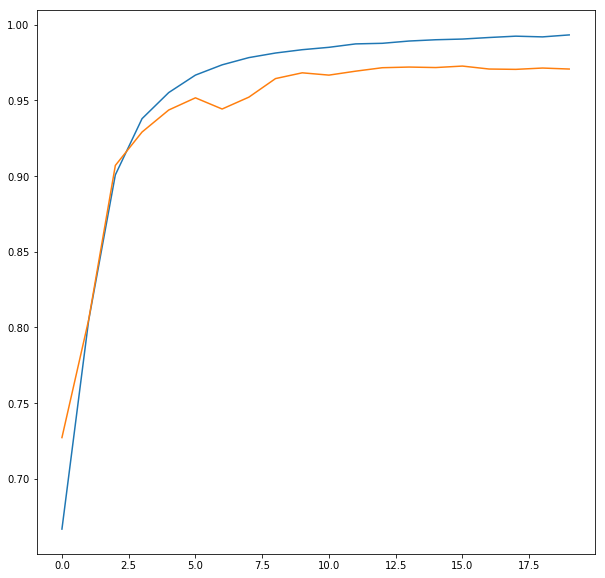

In [7]:
#Plot graphs in the notebook output
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [8]:
# real vs predict matrix using sklearn
from sklearn.metrics import confusion_matrix

p_test = model1.predict(X_tst)
pred_test = np.argmax(p_test, axis=1)

print(confusion_matrix(y_tst, pred_test)[:15,:15])


[[ 23   0   3   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1  31   0   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 101   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   8   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   8   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  32   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  28]]
